In [16]:
from glob import glob

scores = {"intersec": {}, "algnWoutOffs": {}}

#Iterate over simulation results
for m in scores.keys():
    for f in glob(f"../simulations/scores_mes{m}_s20620220951_n100_l10008_m*.txt"):
        #Parse mutation rate from file name
        mRate = float(f.split("_m")[2].split("_i")[0])
        #Initialize a score list for each mutation rate
        scores[m][mRate] = []

        for l in open(f, 'r'):
            scores[m][mRate].append(int(l))

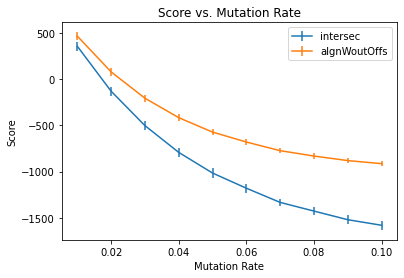

In [17]:
from matplotlib import pyplot as plt
from numpy import mean, std

rateRange = sorted(scores["algnWoutOffs"].keys())

for m in scores.keys():
    plt.errorbar(rateRange, [mean(scores[m][r]) for r in rateRange], yerr=[std(scores[m][r]) for r in rateRange], \
                label=m)
    
plt.title("Score vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.legend()
plt.show()

# Homology Scores

In [1]:
#Mapping between a nucleotide character and its bitwise representation
NT_IN_BITS = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#This function calculates the hash of a bitwise k-mer representation. The function is influenced by the code of "The minimizer Jaccard estimator is 
#biased and inconsistent." from Belbasi et al. (function "minimap2_hash(seed,v,mask)" in file "minimap2_hash_uncompiled.py").
def getHash(kmer, mask):
    u = kmer & mask
    u = ((~u) + (u << 21)) & mask # u = (u<<21)-(u+1) = 77594587*u-1
    u = u ^ (u >> 24)
    u = ((u + (u << 3)) + (u << 8)) & mask # u *= 265
    u = u ^ (u >> 14)
    u = ((u + (u << 2)) + (u << 4)) & mask # u *= 21
    u = u ^ (u >> 28)
    u = (u + (u << 31)) & mask # u *= 2147483649

    return u

#This function calculates the sketch of a sequence. It is influenced by the code of "The minimizer Jaccard estimator is biased and inconsistent."
#from Belbasi et al. (function "hash_sequence(seq,kmerSize,hashFunc,canonical=False)" in file "jaccard_correction_test.py").
def calcSketch(seq, k, thres):
    sketch = []

    #Calculate mask
    mask = (4 ** k) - 1

    #Iterate of all k-mers in sequence
    for i in range(len(seq) - k + 1):
        kmerBits = 0

        #Get bit representation of k-mer
        for c in seq[i:i+k]:
            kmerBits = (kmerBits << 2) + NT_IN_BITS[c]

        #Calculate hash
        kmerHash = getHash(kmerBits, mask)

        #Add hash to sketch if it is small enough
        if kmerHash <= thres:
            sketch.append((i, kmerHash))

    return sketch

In [145]:
from glob import glob
from math import floor

#K-mer length
K = 9

def getTextSketches(filesPath):
    #Dictionary to store sketches of all texts
    textSketches = {}
    
    #Calculate sketches of sequences
    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        #Initialize new list
        textSketches[mRate] = []
        #Calculate hash threshold
        thres = floor(((4 ** K) - 1) * 0.1)
    
        for l in open(f, 'r'):
            textSketches[mRate].append(calcSketch(l.strip().split(' ')[1], K, thres))
        
    return textSketches
        
textSketches = getTextSketches("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*")

In [132]:
##Load found t-homologies##

#A dictionary for all scores
scores = {}
#A dictionary to store the number ob found t-homologies per pair
homsPerPair = {}
#A dictionary to store the percentage of coverage of real homologies by t-homologies
percCovs = {}
#A dictionary to store start end stop positions of all t-homologies
coords = {}

for f in glob("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*"):
    #Get mutation rate
    mRate = float(f.split("_m")[1].split("_i")[0])
    lastPairID = 1
    nbHoms = 0
    
    #Initialize new lists
    for d in scores, homsPerPair, percCovs, coords:
        d[mRate] = []
    
    for l in open(f, 'r'):
        l.strip()
        
        if l.startswith("Pair"):
            pairID = int(l.split(' ')[1])
            coords[mRate].append([])
            continue
            
        if l.startswith('['):
            #Get score
            scores[mRate].append(int(l.split(' ')[1]))
            #Get start position in sequence
            start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0])][0]
            #Get end position in sequence
            end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0])][0]
            #Save start and end coordinates
            coords[mRate][-1].append((start, end))
            #Add sequence coverage
            percCovs[mRate].append((end - start) / 5000.)
            
            #Check if we are dealing with a new pair
            if lastPairID != pairID:
                homsPerPair[mRate].append(nbHoms)
                nbHoms = 0
                lastPairID = pairID
                
            #Count homologies for this pair
            nbHoms += 1
    
    homsPerPair[mRate].append(nbHoms)
    
    #Testing
    #print("len(coords[mRate])", len(coords[mRate]))

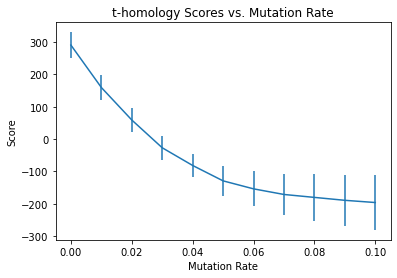

In [48]:
from matplotlib import pyplot as plt
from numpy import mean, std

rates = sorted(scores.keys())
plt.errorbar(rates, [mean(scores[r]) for r in rates], yerr=[std(scores[r]) for r in rates])    
plt.title("t-homology Scores vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Score")
plt.show()

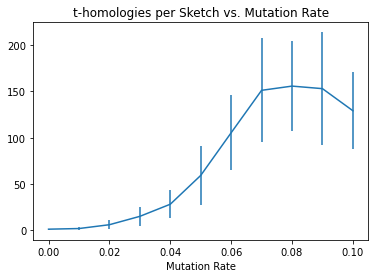

In [49]:
rates = sorted(homsPerPair.keys())
plt.errorbar(rates, [mean(homsPerPair[r]) for r in rates], yerr=[std(homsPerPair[r]) for r in rates])    
plt.title("t-homologies per Sketch vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.show()

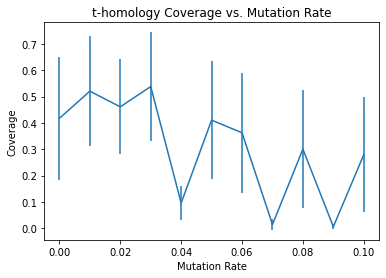

In [133]:
rates = sorted(percCovs.keys())
plt.errorbar(rates, [mean(percCovs[r]) for r in rates], yerr=[std(percCovs[r]) for r in rates])    
plt.title("t-homology Coverage vs. Mutation Rate")
plt.xlabel("Mutation Rate")
plt.ylabel("Coverage")
plt.show()

## Find Threshold Score to Find All Homologies

In [134]:
#Map scores to coordinates
results = {}

for m in scores.keys():
    results[m] = []
    i = 0
    
    for p in coords[m]:
        results[m].append([])
        
        for c in p:
            results[m][-1].append((scores[m][i], c[0], c[1]))
            i += 1

In [151]:
#Load pattern sketches
def loadPatternSketches(filesPath):
    patternSketches = {}

    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        #Initialize new list
        patternSketches[mRate] = []
        #Calculate hash threshold
        thres = floor(((4 ** K) - 1) * 0.1)
    
        for l in open(f, 'r'):
            patternSketches[mRate].append(calcSketch(l.strip().split(' ')[0], K, thres))
        
    return patternSketches

patternSketches = loadPatternSketches("../simulations/searchPairs_gn100_rn400_gl1000_rl500_o3_m0*")

In [153]:
#Calculate initial homology intervals
def calcHomIntervals(textSketches, patternSketches, iniHomStart, iniHomEnd, homSteps):
    homInts = {}

    for m in textSketches.keys():
        homInts[m] = []
    
        for i in range(len(textSketches[m])):
            patternHashes = [p[1] for p in patternSketches[m][i]]
            homInts[m].append([])
            nextHomStart = iniHomStart
            nextHomEnd = iniHomEnd
        
            #Testing
            #first = True
        
            for h in textSketches[m][i]:
                if nextHomStart < nextHomEnd:
                    if h[1] in patternHashes and h[0] >= nextHomStart and h[0] <= nextHomEnd:
                    
                        #Testing
                        #if m == 0.0 and i == 0 and first:
                        #    print(h[1])
                        #    print("At position", h[0])
                        #    first = False
                        
                        homInts[m][i].append([h[0], h[0]])
                        nextHomStart += homSteps
                else:
                    if h[1] in patternHashes and h[0] <= nextHomEnd:
                        homInts[m][i][-1][1] = h[0]
                
                    if h[0] > nextHomEnd:
                        nextHomEnd += homSteps
                    
    return homInts    

homInts = calcHomIntervals(textSketches, patternSketches, 500, 1500, 1500)

In [126]:
#Testing
firstPairPattern = [p[1] for p in patternSketches[0][0]]
patternFromScript = [6819, 4825, 2786, 17024, 11466, 9845, 14117, 16318, 15893, 26111, 15483, 23409, 22874, 22613, 16477, 14592, 10367, 5826, 22632, 11640, 24216, 15968, 1870, 13045, 22837, 3813, 15651, 1424, 16826, 21844, 22333, 4823, 16707, 19329, 25866, 20378, 8250, 17955, 19157, 12068, 7770, 15692, 3559, 25420, 22007, 8527, 202, 12274, 22915, 4289, 16148, 21313, 7970, 1126, 9397, 13802, 18349, 23990, 22671, 7396, 14256, 16772, 23997, 2904, 16824, 13492, 9498, 13999, 3964, 16617, 15133, 16170, 20002, 2809, 2582, 10391, 25520, 8973, 10031, 19638, 20844, 14615, 10164, 3754]

if firstPairPattern == patternFromScript:
    print("Patterns are equal")
else:
    print("Patterns are NOT equal")
    
patternFromScript.index(20729)

Patterns are equal


ValueError: 20729 is not in list

In [210]:
from math import inf

def findMinScores(results, homInts):
    #Find threshold score
    minScores = {}

    for m in results.keys():
        minScore = inf
    
        for i in range(len(results[m])):
            pairResults = sorted(results[m][i], key=lambda r: r[0], reverse=True)
            intervals = list(homInts[m][i])
        
            while pairResults and intervals:
                res = pairResults.pop(0)
                newIntervals = []
            
                for intv in intervals:
                    #t-homology overlaps end of interval
                    if res[1] >= intv[0] and res[1] <= intv[1]:
                        #t-homology does not overlap interval's start
                        if res[1] - intv[0] > 0:
                            newIntervals.append([intv[0], res[1] - 1])
                    #t-homology overlaps start of interval
                    if res[2] >= intv[0] and res[2] < intv[1]:
                        newIntervals.append([res[2] + 1, intv[1]])
                    #t-homology starts behind interval
                    if res[1] > intv[1]:
                        newIntervals.append(intv)
                    #t-homology ends in front of interval
                    if res[2] < intv[0]:
                        newIntervals.append(intv)
                      
                #Testing
                #print("res:", res)
                #print("intervals:", intervals)
                #print("newIntervals:", newIntervals)
            
                intervals = newIntervals
            
                if minScore > res[0]:
                    minScore = res[0]
                
        minScores[m] = minScore
        
    return minScores

In [149]:
minScores = findMinScores(results, homInts)

minScores

{0.06: -123,
 0.01: -95,
 0.09: -387,
 0.07: -390,
 0.05: -122,
 0.0: 158,
 0.08: -142,
 0.1: -162,
 0.03: -56,
 0.04: -352,
 0.02: -276}

In [136]:
for m in results.keys():
    print(m, min([r[0] for p in results[m] for r in p]))

0.06 -345
0.01 -312
0.09 -387
0.07 -390
0.05 -317
0.0 -139
0.08 -416
0.1 -450
0.03 -141
0.04 -362
0.02 -361


In [428]:
#Load non-unit score results

def loadHomologies(filesPath, textSketches, normScrs):
    res = {}

    for f in glob(filesPath):
        #Get mutation rate
        mRate = float(f.split("_m")[1].split("_i")[0])
        lastPairID = 1
        patternPrinted = False
        res[mRate] = []
    
        for l in open(f, 'r'):
            l.strip()
        
            if l.startswith("Pair"):
                pairID = int(l.split(' ')[1])
                res[mRate].append([])
                continue
                
            if l.startswith("Pattern"):
                patternLen = len(l.split(','))
                patternPrinted = True
            
            if l.startswith('['):
                #Get start position in sequence
                start = textSketches[mRate][pairID - 1][int(l.split('[')[1].split(',')[0])][0]
                #Get end position in sequence
                end = textSketches[mRate][pairID - 1][int(l.split(',')[1].split(']')[0])][0]
                score = int(l.split(' ')[1])
                
            if l.startswith("maxNbSketches(pattern,text):"):
                if normScrs:
                    if not patternPrinted:
                        score /= float(l.split("): ")[1])
                    else:    
                        substringLen = int(l.split(',')[1].split(']')[0]) - int(l.split(',')[1].split(']')[0]) + 1
                        score /= max(patternLen, substringLen)
                    
                #Save score, start and end coordinates
                res[mRate][-1].append((score, start, end))
            
    return res

In [ ]:
nonUnitRes = loadHomologies("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u3.txt", textSketches)
print(nonUnitRes[0])

In [131]:
nonUnitMinScores = findMinScores(nonUnitRes, homInts)

nonUnitMinScores

{0.06: -360,
 0.05: -382,
 0.09: -387,
 0.08: -381,
 0.01: -95,
 0.1: -373,
 0.03: -315,
 0.07: -390,
 0.0: 158,
 0.02: -276,
 0.04: -352}

In [102]:
for m in nonUnitRes.keys():
    print(m, min([r[0] for p in nonUnitRes[m] for r in p]))

0.06 -360
0.05 -382
0.09 -387
0.08 -381
0.01 -312
0.1 -373
0.03 -382
0.07 -390
0.0 -139
0.02 -361
0.04 -362


In [180]:
#Load nucmer results
nucmerResDef = loadNucmerRes("../simulations/nucmerAlignments_gn100_rn400_gl1000_rl500_o3_m0*.coords")

{0.05: [[[-inf, 501, 1495], [-inf, 2009, 2991], [-inf, 3501, 4496]],
  [[-inf, 505, 1495], [-inf, 2002, 2987], [-inf, 3501, 4491]],
  [[-inf, 501, 1496], [-inf, 2004, 2990], [-inf, 3501, 4503]],
  [[-inf, 501, 1491], [-inf, 2001, 2997], [-inf, 3501, 4482]],
  [[-inf, 511, 1489], [-inf, 2010, 2995], [-inf, 3509, 4492]],
  [[-inf, 503, 1484], [-inf, 2005, 3000], [-inf, 3521, 4488]],
  [[-inf, 504, 1498], [-inf, 2001, 2988], [-inf, 3501, 4488]],
  [[-inf, 2001, 2997]],
  [[-inf, 505, 1477], [-inf, 2001, 2995], [-inf, 3501, 4499]],
  [[-inf, 501, 1484], [-inf, 2001, 2985]],
  [[-inf, 504, 1496], [-inf, 2001, 2986], [-inf, 3501, 4495]],
  [[-inf, 501, 1492], [-inf, 2001, 2991], [-inf, 3505, 4500]],
  [[-inf, 2001, 2988], [-inf, 3514, 4493]],
  [[-inf, 2001, 2997], [-inf, 3501, 4495]],
  [[-inf, 504, 1496], [-inf, 2001, 2999], [-inf, 3501, 4494]],
  [[-inf, 501, 1492], [-inf, 3501, 4499]],
  [[-inf, 501, 1485], [-inf, 2001, 2993]],
  [[-inf, 513, 1499], [-inf, 3501, 4492]],
  [[-inf, 506, 14

In [183]:
#Load maxmatch nucmer results
nucmerResMaxmatch = loadNucmerRes("../simulations/nucmerAlignments_gn100_rn400_gl1000_rl500_o3_m0*_maxmatch_p*" + \
                                  ".coords")

{0.1: [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 723, 1474]],
  [],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 501, 1388]],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 0.05: [[[-inf, 501, 1495], [-inf, 2009, 2991], [-inf, 3501, 4496]],
  [[-inf, 505, 1495], [-inf, 2002, 2987], [-inf, 3501, 4491]],
  [[-inf, 501, 1496], [-inf, 2004, 2990], [-inf, 3501, 4503]],
  [[-inf, 501, 1491], [-inf, 2001, 2997], [-inf, 3501, 4482]],
  [[-inf, 511, 1489], [-inf, 2010, 2995], [-inf, 3509, 4492]],
  [[-inf, 503, 1484], [-inf, 2005, 3000

In [193]:
#How many nucmer results do we find per search pair?
nucmerRes = [nucmerResDef, nucmerResMaxmatch]
resDesc = ["Nucmer Default:", "Nucmer --maxmatch:"]

for i in range(len(nucmerRes)):
    print(resDesc[i])
    
    for m in sorted(nucmerRes[i].keys()):
        nbResPerPair = [len(p) for p in nucmerRes[i][m]]

        print("Mut. Rate:", m, "Min:", min(nbResPerPair), "Max:", max(nbResPerPair), "Avg.:", mean(nbResPerPair), \
          "Std.:", std(nbResPerPair))

Nucmer Default:
Mut. Rate: 0.0 Min: 0 Max: 0 Avg.: 0.0 Std.: 0.0
Mut. Rate: 0.01 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.02 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.03 Min: 2 Max: 3 Avg.: 2.99 Std.: 0.09949874371066199
Mut. Rate: 0.04 Min: 2 Max: 3 Avg.: 2.84 Std.: 0.36660605559646725
Mut. Rate: 0.05 Min: 0 Max: 3 Avg.: 2.36 Std.: 0.6711184694225006
Mut. Rate: 0.06 Min: 0 Max: 3 Avg.: 1.28 Std.: 0.8494704232638121
Mut. Rate: 0.07 Min: 0 Max: 3 Avg.: 0.48 Std.: 0.6554387843269577
Mut. Rate: 0.08 Min: 0 Max: 2 Avg.: 0.22 Std.: 0.4377213725647858
Mut. Rate: 0.09 Min: 0 Max: 1 Avg.: 0.03 Std.: 0.1705872210923198
Mut. Rate: 0.1 Min: 0 Max: 1 Avg.: 0.02 Std.: 0.13999999999999999
Nucmer --maxmatch:
Mut. Rate: 0.0 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.01 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.02 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.03 Min: 3 Max: 3 Avg.: 3.0 Std.: 0.0
Mut. Rate: 0.04 Min: 2 Max: 3 Avg.: 2.93 Std.: 0.2551470164434615
Mut. Rate: 0.05 Min: 

Mutation rate: 0.0


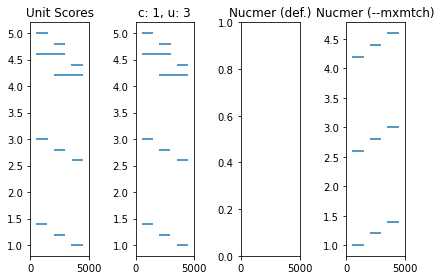

Mutation rate: 0.01


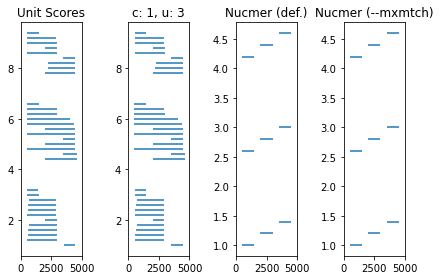

Mutation rate: 0.02


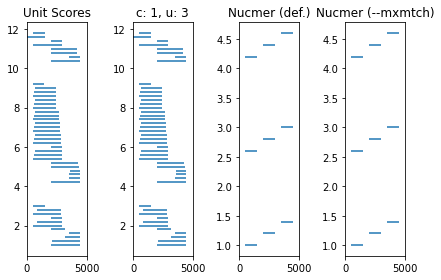

Mutation rate: 0.03


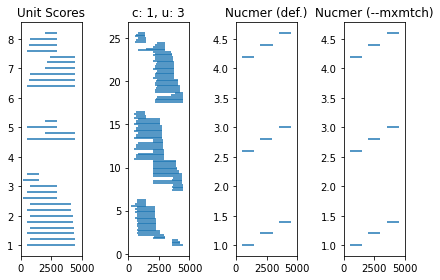

Mutation rate: 0.04


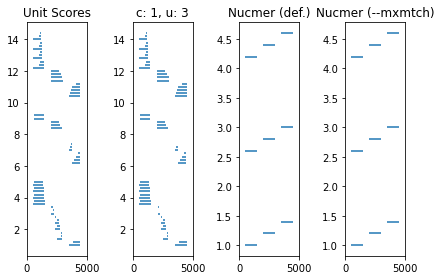

Mutation rate: 0.05


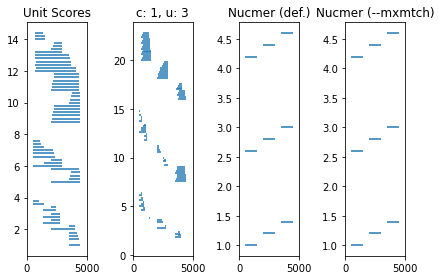

Mutation rate: 0.06


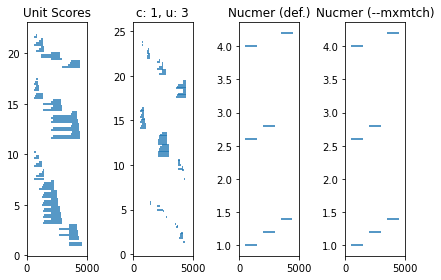

Mutation rate: 0.07


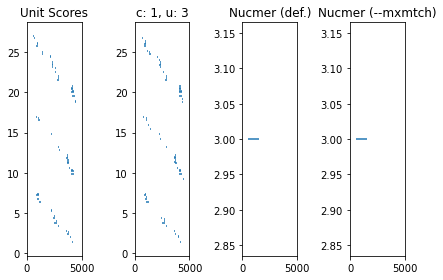

Mutation rate: 0.08


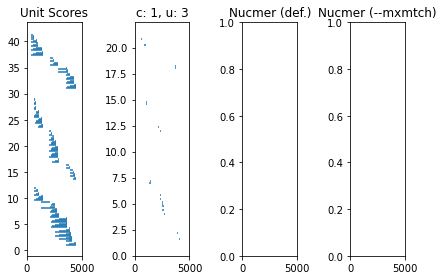

Mutation rate: 0.09


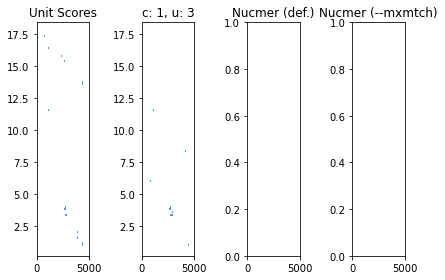

Mutation rate: 0.1


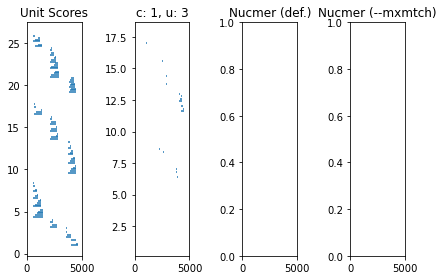

In [186]:
mRates = sorted(results.keys())
allRes = [results, nonUnitRes, nucmerResDef, nucmerResMaxmatch]
allMinScores = [minScores, nonUnitMinScores]
titles = ["Unit Scores", "c: 1, u: 3", "Nucmer (def.)", "Nucmer (--mxmtch)"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, len(allRes))
          
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if i > 1 or p[0] >= allMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
        
        axes[i].set_xlim([0, 5000])
        axes[i].set_title(titles[i])
        
    plt.tight_layout()
    plt.show()

## Duplication Aware $t$-homology Detection

Mutation rate: 0.0


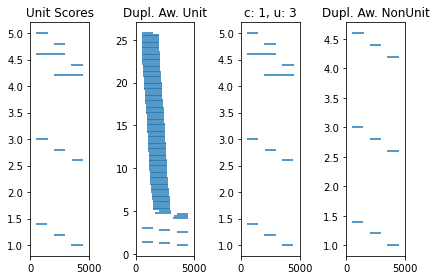

Mutation rate: 0.01


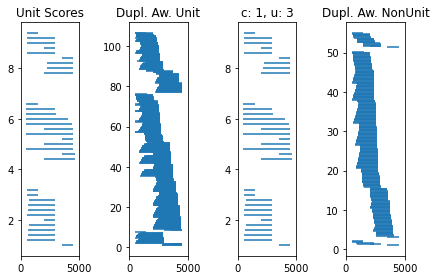

Mutation rate: 0.02


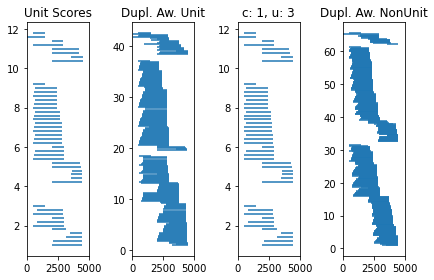

Mutation rate: 0.03


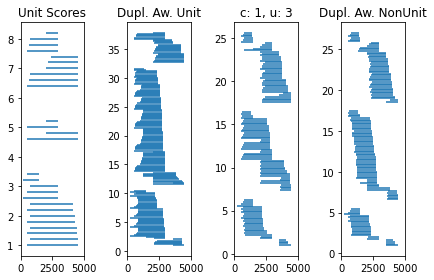

Mutation rate: 0.04


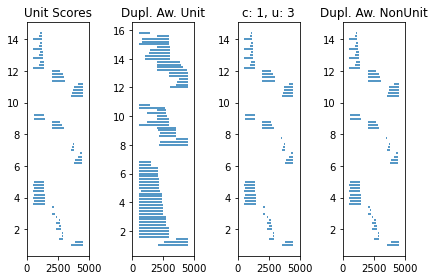

Mutation rate: 0.05


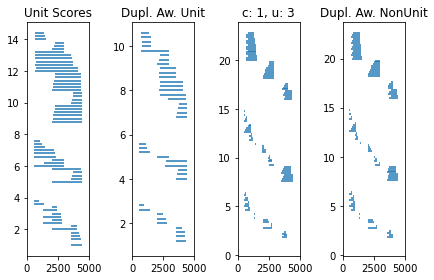

Mutation rate: 0.06


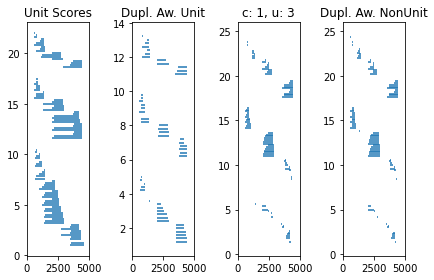

Mutation rate: 0.07


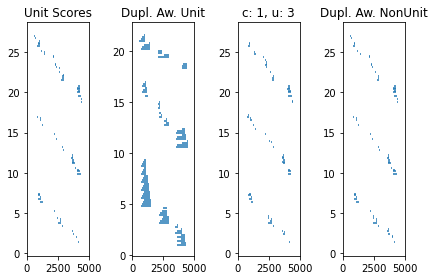

Mutation rate: 0.08


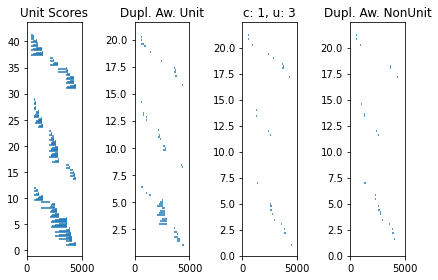

Mutation rate: 0.09


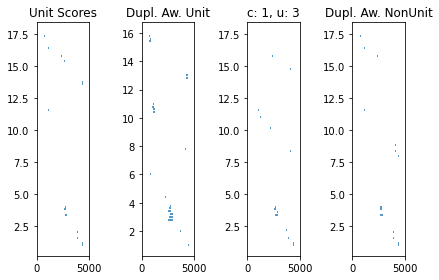

Mutation rate: 0.1


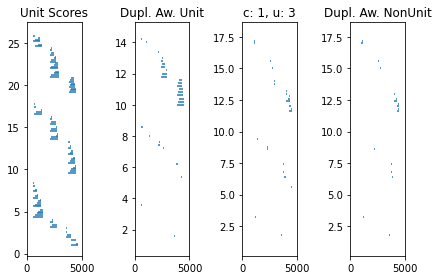

In [201]:
#Load duplication aware results with and without score weight modifications
duplAwUnitRes = loadHomologies("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u1.txt", \
                               textSketches)
duplAwNonUnitRes = loadHomologies("../simulations/homologies_gn100_rn400_gl1000_rl500_o3_m0*_c1_u3.txt", \
                                  textSketches)
#Calculate min score thresholds for new duplication aware results
duplAwUnitMinScores = findMinScores(duplAwUnitRes, homInts)
duplAwNonUnitMinScores = findMinScores(duplAwNonUnitRes, homInts)
#Plot results
mRates = sorted(duplAwUnitRes.keys())
allRes = [results, duplAwUnitRes, nonUnitRes, duplAwNonUnitRes]
allMinScores = [minScores, duplAwUnitMinScores, nonUnitMinScores, duplAwNonUnitMinScores]
titles = ["Unit Scores", "Dupl. Aw. Unit", "c: 1, u: 3", "Dupl. Aw. NonUnit"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, len(allRes))
          
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if p[0] >= allMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
        
        axes[i].set_xlim([0, 5000])
        axes[i].set_title(titles[i])
        
    plt.tight_layout()
    plt.show()

In [221]:
#Testing
#print(homInts[0][0])
#print([i for i in sorted(duplAwUnitRes[0][2], key=lambda r: r[0]) if i[0] >= duplAwUnitMinScores[0]])
#findMinScores({0: [duplAwUnitRes[0][0]]}, homInts)
#duplAwUnitMinScores = findMinScores(duplAwUnitRes, homInts)
#duplAwUnitMinScores
sorted(duplAwUnitRes[0][0], key=lambda r: r[0])

[(113, 1467, 2957),
 (113, 1457, 2951),
 (113, 1451, 2937),
 (113, 1437, 2917),
 (113, 1417, 2884),
 (113, 1384, 2879),
 (113, 1379, 2867),
 (113, 1367, 2857),
 (113, 1357, 2856),
 (113, 1356, 2843),
 (113, 1343, 2834),
 (113, 1334, 2829),
 (113, 1329, 2817),
 (113, 1317, 2809),
 (113, 1309, 2783),
 (113, 1283, 2754),
 (113, 1254, 2750),
 (113, 1250, 2660),
 (113, 1160, 2651),
 (113, 1151, 2650),
 (113, 1150, 2640),
 (113, 1140, 2628),
 (113, 1128, 2626),
 (113, 1126, 2618),
 (113, 1118, 2612),
 (113, 1112, 2575),
 (113, 1075, 2555),
 (113, 1055, 2553),
 (113, 1053, 2549),
 (113, 1049, 2548),
 (113, 1048, 2538),
 (113, 1038, 2528),
 (113, 1028, 2524),
 (113, 1024, 2523),
 (113, 1023, 2476),
 (113, 976, 2467),
 (113, 967, 2466),
 (113, 966, 2461),
 (113, 961, 2453),
 (113, 953, 2448),
 (113, 948, 2442),
 (113, 942, 2435),
 (113, 935, 2413),
 (113, 913, 2405),
 (113, 905, 2384),
 (113, 884, 2379),
 (113, 879, 2357),
 (113, 857, 2349),
 (113, 849, 2346),
 (113, 846, 2340),
 (113, 840, 233

# New Simulations - Single Pattern Occurrence in Text

In [152]:
#Get sketches of new texts
snglPttnTextSketches = getTextSketches("../simulations/searchPairs_gn100_rn200_gl1000_rl1000_o1_m0*")
#Load new results
snglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*", snglPttnTextSketches)
#Calculate pattern sketches for single pattern text pairs
snglPttnPatternSketches = loadPatternSketches("../simulations/searchPairs_gn100_rn200_gl1000_rl1000_o1_m0*")
#Calculate homology intervals for single pattern texts
snglPttnHomInts = calcHomIntervals(snglPttnTextSketches, snglPttnPatternSketches, 1000, 2000, 2500)
#Calculate thresholds
snglPttnMinScores = findMinScores(snglPttnRes, snglPttnHomInts)

print("Threshold scores for single pattern texts:")
print(snglPttnMinScores)
print("Min scores of single pattern texts:")

for m in snglPttnRes.keys():
    print(m, min([r[0] for p in snglPttnRes[m] for r in p]))

2259
At position 1009
Threshold scores for single pattern texts:
{0.1: -119, 0.0: 148, 0.02: -5, 0.07: -119, 0.09: -125, 0.04: -108, 0.08: -119, 0.03: -46, 0.06: -116, 0.01: 53, 0.05: -112}
Min scores of single pattern texts:
0.1 -119
0.0 43
0.02 -108
0.07 -119
0.09 -125
0.04 -111
0.08 -121
0.03 -111
0.06 -118
0.01 -68
0.05 -118


In [174]:
#Load nucmer results
NB_PAIRS = 100

def loadNucmerRes(filePaths):
    res = {}
    
    for f in glob(filePaths):
        mRate = float(f.split("_m")[1].split("_i")[0])
        pairID = int(f.split("_p")[1].split(".coords")[0])
        
        if not mRate in res:
            res[mRate] = [[] for i in range(NB_PAIRS)]
            
        c = 1
        
        for l in open(f, 'r'):
            if c > 5:
                res[mRate][pairID].append([-inf] + [int(i) for i in l.split('|')[0].strip().split(' ') if \
                                                    i.isnumeric()])
                
            c += 1
            
    return res

In [175]:
snglPttnNucRes = loadNucmerRes("../simulations/nucmerAlignments_gn100_rn200_gl1000_rl1000_o1_m0*.coords")

In [176]:
#Testing
snglPttnNucRes

{0.06: [[[-inf, 1001, 1996]],
  [],
  [],
  [[-inf, 1035, 2001]],
  [[-inf, 1001, 1975]],
  [[-inf, 1001, 1981]],
  [[-inf, 1001, 1980]],
  [],
  [],
  [],
  [[-inf, 1001, 1993]],
  [[-inf, 1001, 1975]],
  [],
  [[-inf, 1001, 1985]],
  [[-inf, 1001, 1984]],
  [[-inf, 1005, 1991]],
  [],
  [],
  [],
  [[-inf, 1001, 1996]],
  [],
  [[-inf, 1001, 1993]],
  [],
  [[-inf, 1004, 1991]],
  [],
  [[-inf, 1001, 1993]],
  [[-inf, 1003, 1988]],
  [[-inf, 1004, 1987]],
  [[-inf, 1001, 1988]],
  [],
  [[-inf, 1001, 1998]],
  [],
  [[-inf, 1002, 1992]],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 1008, 1965]],
  [],
  [],
  [],
  [[-inf, 1004, 1992]],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 1001, 1988]],
  [],
  [[-inf, 1001, 1975]],
  [[-inf, 1004, 1978]],
  [],
  [],
  [],
  [],
  [[-inf, 1001, 1990]],
  [],
  [[-inf, 1008, 2004]],
  [[-inf, 1001, 1965]],
  [[-inf, 1001, 1990]],
  [[-inf, 1004, 1980]],
  [[-inf, 1012, 1991]],
  [],
  [],
  [],
  [],
  [],
  [[-inf, 1001, 1993]],
  [],
  [],
  [],
  []

Mutation rate: 0.0


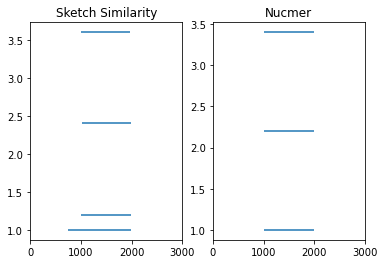

Mutation rate: 0.01


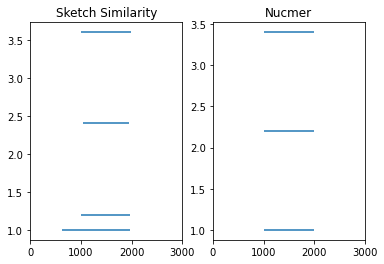

Mutation rate: 0.02


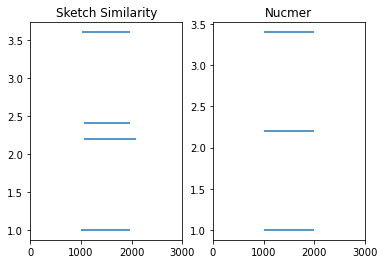

Mutation rate: 0.03


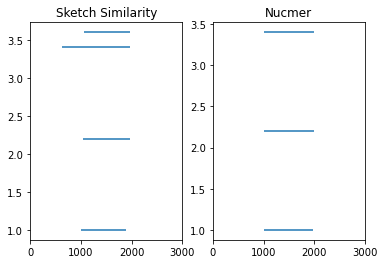

Mutation rate: 0.04


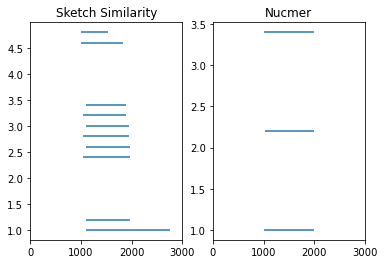

Mutation rate: 0.05


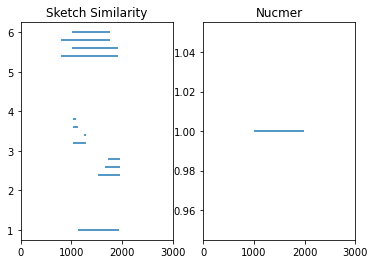

Mutation rate: 0.06


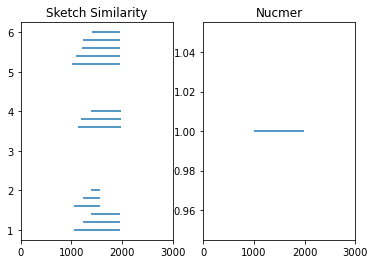

Mutation rate: 0.07


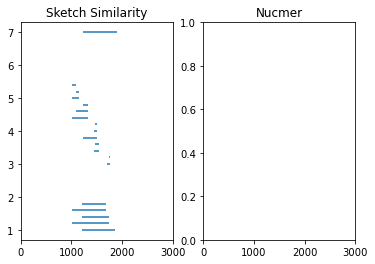

Mutation rate: 0.08


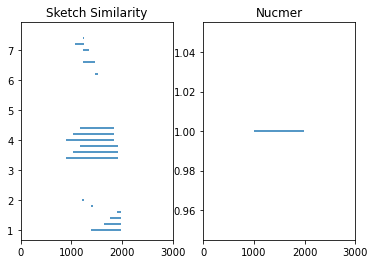

Mutation rate: 0.09


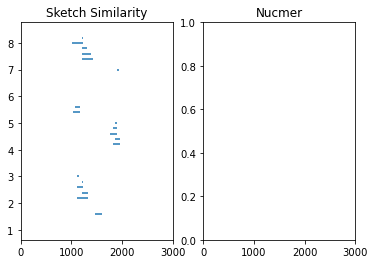

Mutation rate: 0.1


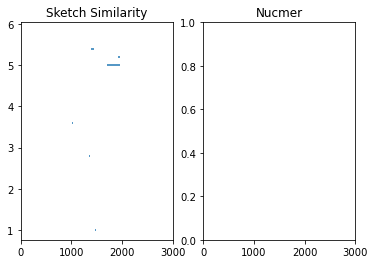

In [179]:
mRates = sorted(snglPttnRes.keys())
allRes = [snglPttnRes, snglPttnNucRes]
titles = ["Sketch Similarity", "Nucmer"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, 2)
    
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if i == 1 or p[0] >= snglPttnMinScores[m]]
            
            #Testing
            #print(toPlot)
            
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
            axes[i].set_xlim([0, 3000])
            
        axes[i].set_title(titles[i])
        
    plt.show()

## Duplication Aware $t$-homology Detection

Mutation rate: 0.0


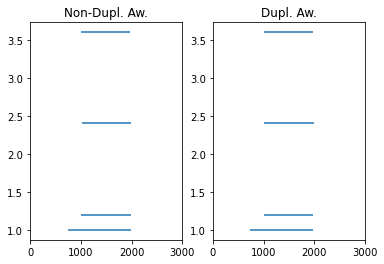

Mutation rate: 0.01


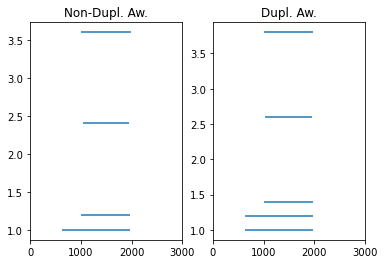

Mutation rate: 0.02


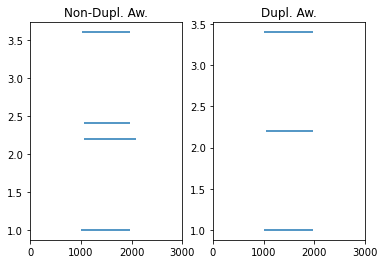

Mutation rate: 0.03


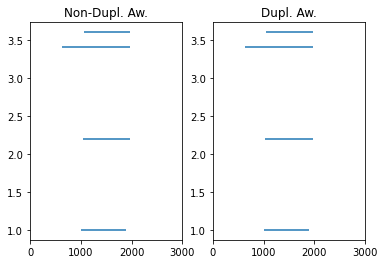

Mutation rate: 0.04


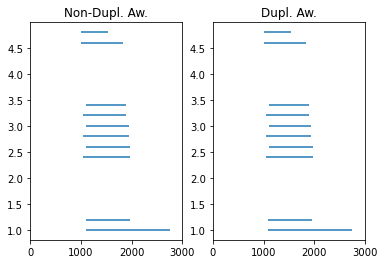

Mutation rate: 0.05


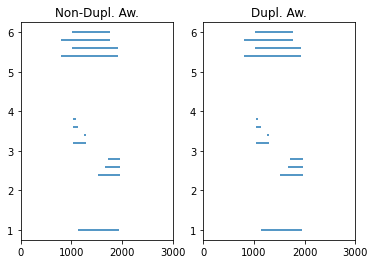

Mutation rate: 0.06


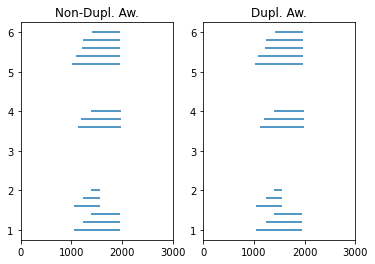

Mutation rate: 0.07


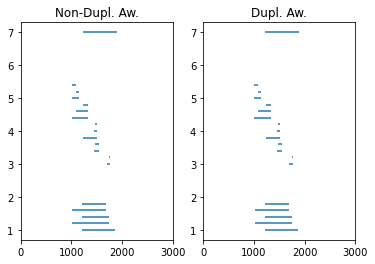

Mutation rate: 0.08


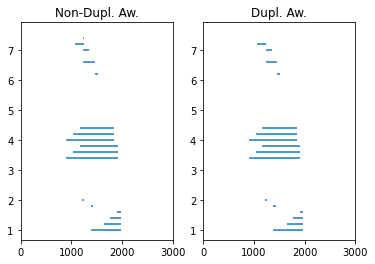

Mutation rate: 0.09


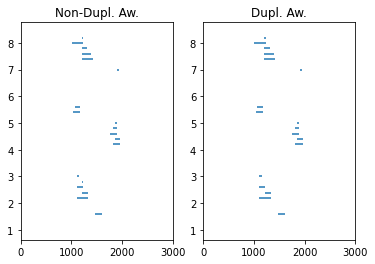

Mutation rate: 0.1


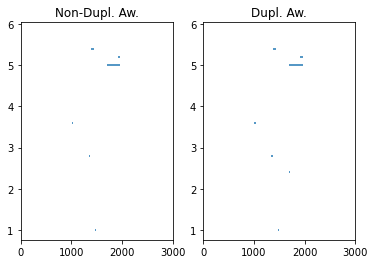

In [429]:
duplAwSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*_u1.txt", \
                                   snglPttnTextSketches, False)
duplAwSnglPttnMinScores = findMinScores(duplAwSnglPttnRes, snglPttnHomInts)
mRates = sorted(snglPttnRes.keys())
allRes = [snglPttnRes, duplAwSnglPttnRes]
allSnglPttnMinScores = [snglPttnMinScores, duplAwSnglPttnMinScores]
titles = ["Non-Dupl. Aw.", "Dupl. Aw."]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, 2)
    
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
            axes[i].set_xlim([0, 3000])
            
        axes[i].set_title(titles[i])
        
    plt.show()

In [438]:
mRates = sorted(snglPttnRes.keys())
allRes = [snglPttnRes, duplAwSnglPttnRes]
allSnglPttnMinScores = [snglPttnMinScores, duplAwSnglPttnMinScores]
titles = ["Non-Dupl. Aw.", "Dupl. Aw."]

print("Average number of t-homologies above threshold")

for m in mRates:
    print("Mutation rate:", m)
    
    for i in range(len(allRes)):
        nbRes = []
        
        for ps in allRes[i][m]:
            nbRes.append(len([p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]))
            
        print(f"{titles[i]}: mean:{mean(nbRes)}, std:{std(nbRes)}")

Average number of t-homologies above threshold
Mutation rate: 0.0
Non-Dupl. Aw.: mean:1.35, std:0.6062177826491072
Dupl. Aw.: mean:1.19, std:0.39230090491866065
Mutation rate: 0.01
Non-Dupl. Aw.: mean:1.41, std:0.6647555941848102
Dupl. Aw.: mean:1.29, std:0.5530822723609934
Mutation rate: 0.02
Non-Dupl. Aw.: mean:1.75, std:1.4026760139105539
Dupl. Aw.: mean:1.62, std:1.2631706139710501
Mutation rate: 0.03
Non-Dupl. Aw.: mean:1.72, std:0.8009993757800314
Dupl. Aw.: mean:1.63, std:0.743706931526122
Mutation rate: 0.04
Non-Dupl. Aw.: mean:3.46, std:2.4956762610563095
Dupl. Aw.: mean:3.51, std:2.6134077370360713
Mutation rate: 0.05
Non-Dupl. Aw.: mean:5.06, std:3.13949040450835
Dupl. Aw.: mean:5.09, std:3.212771389314839
Mutation rate: 0.06
Non-Dupl. Aw.: mean:7.51, std:4.186872341020203
Dupl. Aw.: mean:7.55, std:4.200892762258993
Mutation rate: 0.07
Non-Dupl. Aw.: mean:9.02, std:4.002449250146714
Dupl. Aw.: mean:9.01, std:4.041027097162305
Mutation rate: 0.08
Non-Dupl. Aw.: mean:8.72, std

## Using Length Normalized Scores

Mutation rate: 0.0


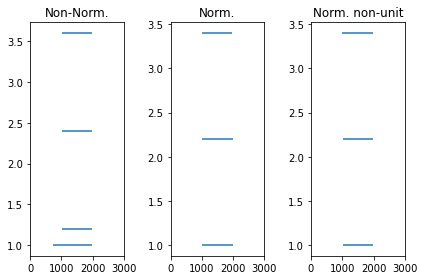

Mutation rate: 0.01


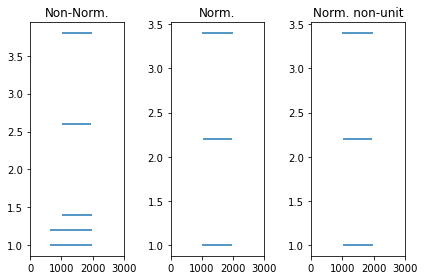

Mutation rate: 0.02


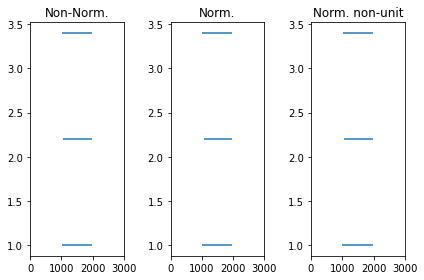

Mutation rate: 0.03


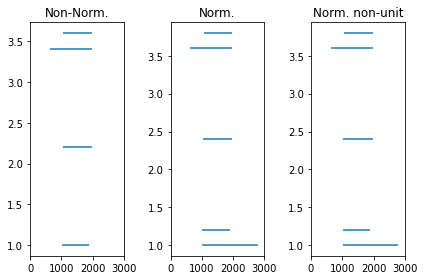

Mutation rate: 0.04


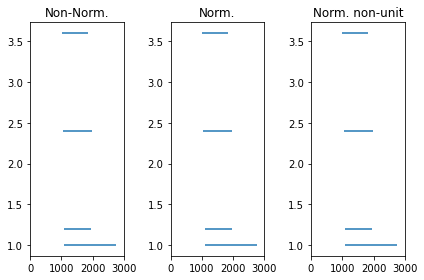

Mutation rate: 0.05


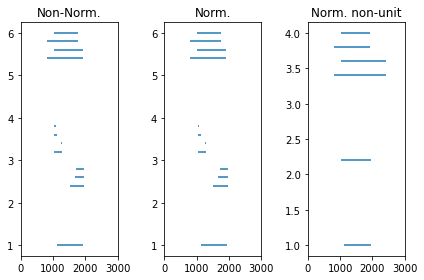

Mutation rate: 0.06


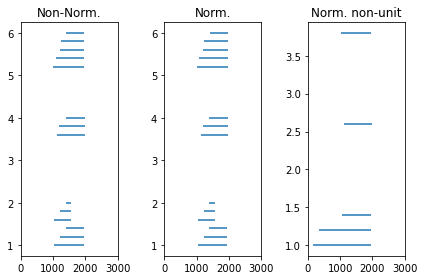

Mutation rate: 0.07


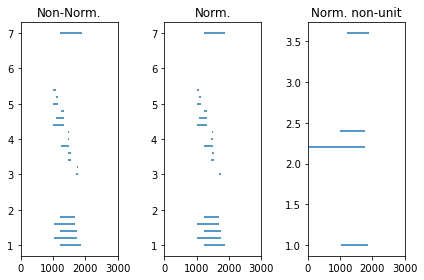

Mutation rate: 0.08


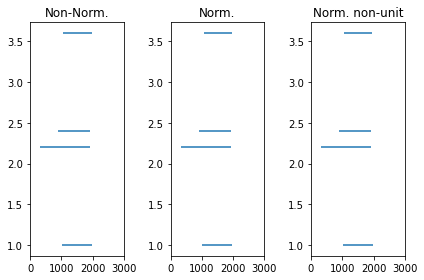

Mutation rate: 0.09


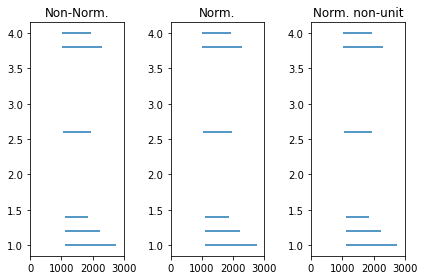

Mutation rate: 0.1


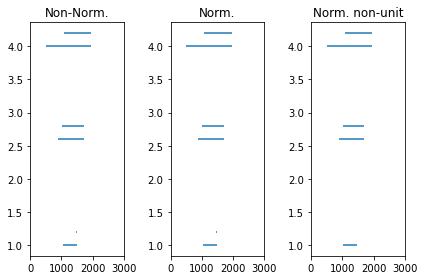

In [436]:
nonNormDuplAwSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*_u1.txt", \
                                   snglPttnTextSketches, False)
normDuplAwSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*_u1.txt", \
                                   snglPttnTextSketches, True)
normDuplAwNonUnitSnglPttnRes = loadHomologies("../simulations/homologies_gn100_rn200_gl1000_rl1000_o1_m0*c9_u1.txt"\
                                              , snglPttnTextSketches, True)
nonNormDuplAwSnglPttnMinScores = findMinScores(nonNormDuplAwSnglPttnRes, snglPttnHomInts)
normDuplAwSnglPttnMinScores = findMinScores(normDuplAwSnglPttnRes, snglPttnHomInts)
normDuplAwNonUnitSnglPttnMinScores = findMinScores(normDuplAwNonUnitSnglPttnRes, snglPttnHomInts)
mRates = sorted(nonNormDuplAwSnglPttnRes.keys())
allRes = [nonNormDuplAwSnglPttnRes, normDuplAwSnglPttnRes, normDuplAwNonUnitSnglPttnRes]
allSnglPttnMinScores = [nonNormDuplAwSnglPttnMinScores, normDuplAwSnglPttnMinScores, \
                        normDuplAwNonUnitSnglPttnMinScores]
titles = ["Non-Norm.", "Norm.", "Norm. non-unit"]

for m in mRates:
    print("Mutation rate:", m)
    
    fig, axes = plt.subplots(1, len(titles))
    
    for i in range(len(allRes)):
        maxY = 1.
        padding = 0.2
          
        for ps in allRes[i][m][:3]:
            toPlot = [p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]
            axes[i].hlines([maxY + j * padding for j in range(len(toPlot))], [t[1] for t in toPlot], [t[2] for t \
                                                                                                      in toPlot])
            maxY += 1. + padding * len(toPlot)
            axes[i].set_xlim([0, 3000])
            
        axes[i].set_title(titles[i])
        
    plt.tight_layout()
    plt.show()

In [439]:
mRates = sorted(nonNormDuplAwSnglPttnRes.keys())
allRes = [nonNormDuplAwSnglPttnRes, normDuplAwSnglPttnRes, normDuplAwNonUnitSnglPttnRes]
allSnglPttnMinScores = [nonNormDuplAwSnglPttnMinScores, normDuplAwSnglPttnMinScores, \
                        normDuplAwNonUnitSnglPttnMinScores]
titles = ["Non-Norm.", "Norm.", "Norm. non-unit"]

print("Average number of t-homologies above threshold")

for m in mRates:
    print("Mutation rate:", m)
    
    for i in range(len(allRes)):
        nbRes = []
        
        for ps in allRes[i][m]:
            nbRes.append(len([p for p in ps if p[0] >= allSnglPttnMinScores[i][m]]))
            
        print(f"{titles[i]}: mean:{mean(nbRes)}, std:{std(nbRes)}")

Average number of t-homologies above threshold
Mutation rate: 0.0
Non-Norm.: mean:1.42, std:0.6193545026880809
Norm.: mean:1.0, std:0.0
Norm. non-unit: mean:1.0, std:0.0
Mutation rate: 0.01
Non-Norm.: mean:1.58, std:0.7639371701913711
Norm.: mean:1.05, std:0.21794494717703367
Norm. non-unit: mean:1.05, std:0.21794494717703367
Mutation rate: 0.02
Non-Norm.: mean:1.69, std:1.3615799645999498
Norm.: mean:1.24, std:0.512249938994628
Norm. non-unit: mean:1.24, std:0.512249938994628
Mutation rate: 0.03
Non-Norm.: mean:1.63, std:0.743706931526122
Norm.: mean:1.93, std:1.0124722218411724
Norm. non-unit: mean:1.53, std:0.7543871685016919
Mutation rate: 0.04
Non-Norm.: mean:1.7, std:0.9643650760992953
Norm.: mean:1.63, std:0.7570336848516056
Norm. non-unit: mean:1.63, std:0.7570336848516056
Mutation rate: 0.05
Non-Norm.: mean:5.09, std:3.212771389314839
Norm.: mean:5.1, std:3.189043743820395
Norm. non-unit: mean:1.54, std:0.8534635317340749
Mutation rate: 0.06
Non-Norm.: mean:7.55, std:4.2008927

# Precision and Recall Evaluation of minimap2

### Evaluation Criteria

* Only primary mappings are considered for evaluation.
* We use minimap2's default mapping strategy for ONT data as presented on their website.
* A read is considered correctly mapped if true read position and mapping
    * lie on the same chromosome,
    * lie on the same strand
    * and overlap by at least {50, 80, 90, 95, 99}%.

In [338]:
THRESHOLDS = [0.5, 0.8, 0.9, 0.95, 0.99]

In [22]:
MAXOFFS = range(0, 1100, 100)

In [10]:
import gzip
from Bio import SeqIO
from glob import glob
from math import inf

def compareMappingAndTruth(pathToRef, pathToTruthRegEx, pathToMapping):
    #Load chromosome names from reference
    chromNames = [r.id for r in SeqIO.parse(open(pathToRef, 'r'), "fasta")]
    
    #Load truth
    readInfos = {}
    
    for f in glob(pathToTruthRegEx):
        cnt = 0
    
        for l in gzip.open(f, 'rt'):
            cnt += 1
            elems = [e for e in l.strip().split(' ') if e != ""]
            
            #Get infos from reference line
            if cnt % 4 == 2:
                start = int(elems[2])
                length = int(elems[3])
            
            #Get infos from read line and save
            if cnt % 4 == 3:
                curChromName = chromNames[int(elems[1].split('S')[1].split('_')[0]) - 1]
                readInfos[elems[1]] = [curChromName, elems[4], start, start + length - 1]
                
    #Load SAM file
    cnt = 0
    nbSndAlgns = 0
    nbSuplAlgns = 0
    
    for l in gzip.open(pathToMapping, 'rt'):
        cnt += 1
        isSuplAlgn = False
        
        #We are not interested in header lines
        if l.startswith('@'):
            continue
            
        elems = l.split('\t')
        strandsEqual = readInfos[elems[0]][1] == '+'    
        elems[1] = int(elems[1])
        
        #We have a supplementary alignment...whatever that means...
        if elems[1] >= 2048:
            elems[1] -= 2048
            nbSuplAlgns += 1
            isSuplAlgn = True
            
            #print(f"WARNING: Line {cnt} in SAM file is marked as supplementary alignment. Read name is {elems[0]}")
                
        #The read was flagged as a duplicate
        if elems[1] >= 1024:
            elems[1] -= 1024
            
            print(f"WARNING: Line {cnt} in SAM file says that a read was flagged as a duplicate")
            
        #A read failed the quality check
        if elems[1] >= 512:
            elems[1] -= 512
            
            print(f"WARNING: Read refered to in Line {cnt} failed the quality check")
            
        #The given alignment is secondary
        if elems[1] >= 256:
            elems[1] -= 256
            nbSndAlgns += 1
            continue
            
        #We have found the second mate of a read pair
        if elems[1] >= 128:
            elems[1] -= 128
            
            print(f"WARNING: In Line {cnt}, we have found the second mate of a read pair")
            
        #We have found the first mate of a read pair
        if elems[1] >= 64:
            elems[1] -= 64
            
            print(f"WARNING: In Line {cnt}, we have found the first mate of a read pair")
            
        #Mate of this guy aligned in reverse direction
        if elems[1] >= 32:
            elems[1] -= 32
            
            print(f"WARNING: In Line {cnt}, we have found a mate who's other mate aligned in reverse direction")
            
        #Read aligned in reverse direction
        if elems[1] >= 16:
            elems[1] -= 16
            
            #Sanity check: Have we seen a mapping for this read before?
            if len(readInfos[elems[0]]) > 4 and not isSuplAlgn:
                print(f"WARNING: In Line {cnt}, we consider a mapping of a read for which we have already " +\
                      "considered a mapping before")
                
            strandsEqual = readInfos[elems[0]][1] == '-'
            
        #Read is part of pair and mate was not aligned
        if elems[1] >= 8:
            elems[1] -= 8
            
            print(f"WARNING: In Line {cnt}, we consider a read whose mate was not aligned")
            
        #Read could not be aligned
        if elems[1] >= 4:
            elems[1] -= 4
            
            #Sanity check: Have we seen a mapping for this read before?
            if len(readInfos[elems[0]]) > 4 and not isSuplAlgn:
                print(f"WARNING: In Line {cnt}, we consider a mapping of a read for which we have already " +\
                      "considered a mapping before")
                
                readInfos[elems[0]][4] = inf
            else:
                readInfos[elems[0]].append(inf)
                
            continue
            
        #Read is part of properly aligned pair
        if elems[1] >= 2:
            elems[1] -= 2
            
            print(f"WARNING: The read considered in Line {cnt} belongs to a properly aligned read pair")
            
        #Read is paired
        if elems[1] >= 1:
            elems[1] -= 1
            
            print(f"WARNING: The read considered in Line {cnt} belongs to a pair")
            
        #Check if read was mapped to the correct chromosome
        chromsEqual = elems[2] == readInfos[elems[0]][0]
        #Calculate end position of mapping
        start = int(elems[3])
        end = start - 1
        nbOps = ""
        
        for c in elems[5]:
            if c.isdigit():
                nbOps += c
            #Run of matches found
            elif c == 'M' or 'D' or 'N' or '=' or 'X':
                end += int(nbOps)
                nbOps = ""
            elif c == 'I' or 'S' or 'H' or 'P':
                nbOps = ""
            else:
                print(f"ERROR: Unrecognized operation {c} detected in CIGAR string in Line {cnt}")
                
        #Check which kind of overlap between true location and mapping we are dealing with
        if readInfos[elems[0]][3] < start or end < readInfos[elems[0]][2]:
            mappingOffset = readInfos[elems[0]][3] - readInfos[elems[0]][2] + end - start + 2
        else:
            #Mapping contained inside true position
            if readInfos[elems[0]][2] < start and readInfos[elems[0]][3] > end:
                #overlap = end - start + 1
                #enoughOverlap = overlap >= (readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1) * overlapThres
                mappingOffset = start - readInfos[elems[0]][2] + readInfos[elems[0]][3] - end + 2
            #Mapping and true position partly overlapping with true position starting earlier
            elif readInfos[elems[0]][2] <= start and readInfos[elems[0]][3] <= end:
                #overlap = readInfos[elems[0]][3] - start
                #enoughOverlap = overlap >= (readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1) * overlapThres
                mappingOffset = start - readInfos[elems[0]][2] + end - readInfos[elems[0]][3] + 2
            #Mapping and true position partly overlapping with mapping starting earlier
            elif start <= readInfos[elems[0]][2] and end <= readInfos[elems[0]][3]:
                #overlap = end - readInfos[elems[0]][2]
                #enoughOverlap = overlap >= (readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1) * overlapThres
                mappingOffset = readInfos[elems[0]][2] - start + readInfos[elems[0]][3] - end + 2
            #True position contained inside mapping
            elif start < readInfos[elems[0]][2] and end > readInfos[elems[0]][3]:
                #overlap = readInfos[elems[0]][3] - readInfos[elems[0]][2] + 1
                #enoughOverlap = overlap >= end - start + 1
                mappingOffset = readInfos[elems[0]][2] - start + end - readInfos[elems[0]][3] + 2
            else:
                print(f"ERROR: Overlap could not be calculated in Line {cnt}\nTrue coordinates: " + \
                      f"{readInfos[elems[0]][2]},{readInfos[elems[0]][3]}\nMapping coordinates: {start},{end}")
                
        #Sanity check: Have we seen a mapping for this read before?
        if len(readInfos[elems[0]]) > 4 and not isSuplAlgn:
            print(f"WARNING: In Line {cnt}, we consider a mapping of a read for which we have already " +\
                      "considered a mapping before")
            
            if chromsEqual and strandsEqual:
                readInfos[elems[0]][4] = mappingOffset
            else:
                readInfos[elems[0]][4] = inf
        else:
            if chromsEqual and strandsEqual:
                readInfos[elems[0]].append(mappingOffset)
            else:
                readInfos[elems[0]].append(inf)
        
    print(f"Comparison done\nSkipped {nbSndAlgns} secondary alignments")
    
    return readInfos

In [337]:
def countMappingOutcomes(readInfos):
    nbNotMapped = 0
    nbMappedCorrectly = 0
    nbMappedIncorrectly = 0

    for r in readInfos:
        if len(readInfos[r]) < 5:
            nbNotMapped += 1
        elif readInfos[r][4]:
            nbMappedCorrectly += 1
        else:
            nbMappedIncorrectly += 1
        
    #Testing
    #print(f"Result of mapping: {nbNotMapped} reads could not be mapped, {nbMappedCorrectly} reads could be " + \
    #      f"mapped correctly and {nbMappedIncorrectly} reads were mapped incorrectly")
    
    return [nbNotMapped, nbMappedCorrectly, nbMappedIncorrectly]

In [344]:
def plotFracOfCorrectMappings(outcomes):
    plt.plot(THRESHOLDS, [float(outcomes[t][1]) / sum(outcomes[t]) for t in THRESHOLDS], 'o-')
    plt.xlabel("Min overlap ratio")
    plt.ylabel("Fraction of correctly mapped reads")
    plt.show()

In [18]:
from matplotlib import pyplot as plt

def plotNbMappingsPerOffset(miniOutcomes, bwaOutcomes):
    for ep in sorted(bwaOutcomes.keys(), key=lambda k: int(k.split(':')[0])):
        plt.plot(MAXOFFS, [len([m for m in miniOutcomes[ep] if miniOutcomes[ep][m][4] <= mo]) / \
                           len(miniOutcomes[ep]) for mo in MAXOFFS], 'o-', label=ep + " (mm2)")
        plt.plot(MAXOFFS, [len([m for m in bwaOutcomes[ep] if bwaOutcomes[ep][m][4] <= mo]) / \
                          len(bwaOutcomes[ep]) for mo in MAXOFFS], '+-', label=ep + " (bwa)")
    
    plt.title("Percent mappings per max offset")
    plt.xlabel("Max offset (bp)")
    plt.ylabel("Fraction of mapped reads")
    plt.legend()
    plt.show()

## Dataset: Salmonella Enterica

In [13]:
miniOutcomesPerPattern = {}

for f in glob("../simulations/minimap2Res/SAL_GB9998AA_AS_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
    
    
    miniOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/SAL_GB9998AA_AS.fasta", \
                                       glob(f"../simulations/reads/SAL_GB9998AA_AS_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/minimap2Res/SAL_GB9998AA_AS_cR103_ep{ep}_s*.sam.gz"\
                                           )[0])

Error pattern: 368:496:736
Comparison done
Skipped 82 secondary alignments
Error pattern: 0:0:0
Comparison done
Skipped 88 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 106 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 94 secondary alignments
Error pattern: 23:31:46
Comparison done
Skipped 70 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 66 secondary alignments


In [15]:
bwaOutcomesPerPattern = {}

for f in glob("../simulations/bwamemRes/SAL_GB9998AA_AS_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
     
    bwaOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/SAL_GB9998AA_AS.fasta", \
                                       glob(f"../simulations/reads/SAL_GB9998AA_AS_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/bwamemRes/SAL_GB9998AA_AS_cR103_ep{ep}_s*.sam.gz")[0])

Error pattern: 368:496:736
Comparison done
Skipped 0 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 0 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 0 secondary alignments
Error pattern: 23:31:46
Comparison done
Skipped 0 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 0 secondary alignments


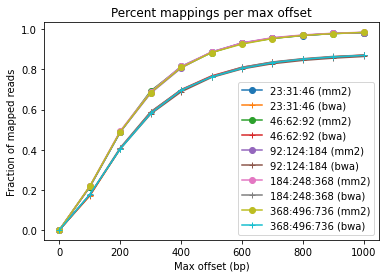

In [23]:
plotNbMappingsPerOffset(miniOutcomesPerPattern, bwaOutcomesPerPattern)

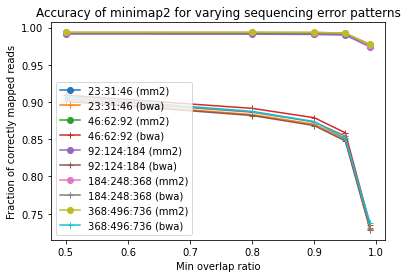

In [370]:
for ep in sorted(bwaOutcomesPerPattern.keys(), key=lambda k: int(k.split(':')[0])):
    plt.plot(THRESHOLDS, [float(outcomesPerPattern[ep][t][1]) / sum(outcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], 'o-', label=ep + " (mm2)")
    plt.plot(THRESHOLDS, [float(bwaOutcomesPerPattern[ep][t][1]) / sum(bwaOutcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], '+-', label=ep + " (bwa)")
    
plt.title("Accuracy of minimap2 for varying sequencing error patterns")
plt.xlabel("Min overlap ratio")
plt.ylabel("Fraction of correctly mapped reads")
plt.legend()
plt.show()

## Dataset: Human Chromosome 22

In [24]:
miniOutcomesPerPattern = {}

for f in glob("../simulations/minimap2Res/humanChr20_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
    
    miniOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       glob(f"../simulations/reads/humanChr20_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/minimap2Res/humanChr20_cR103_ep{ep}_s*.sam.gz")[0])

Error pattern: 23:31:46
Comparison done
Skipped 4180 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 4180 secondary alignments
Error pattern: 368:496:736
Comparison done
Skipped 4180 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 4180 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 4180 secondary alignments


In [25]:
bwaOutcomesPerPattern = {}

for f in glob("../simulations/bwamemRes/humanChr20_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    
    print("Error pattern:", ep)
     
    bwaOutcomesPerPattern[ep] = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       glob(f"../simulations/reads/humanChr20_cR103_ep{ep}_s*.maf.gz")[0], \
                                       glob(f"../simulations/bwamemRes/humanChr20_cR103_ep{ep}_s*.sam.gz")[0])

Error pattern: 23:31:46
Comparison done
Skipped 0 secondary alignments
Error pattern: 46:62:92
Comparison done
Skipped 0 secondary alignments
Error pattern: 368:496:736
Comparison done
Skipped 0 secondary alignments
Error pattern: 184:248:368
Comparison done
Skipped 0 secondary alignments
Error pattern: 92:124:184
Comparison done
Skipped 0 secondary alignments


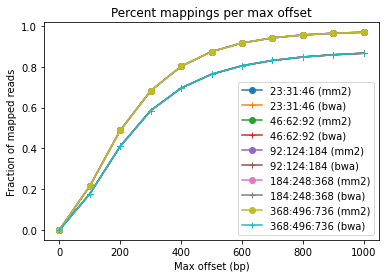

In [26]:
plotNbMappingsPerOffset(miniOutcomesPerPattern, bwaOutcomesPerPattern)

In [384]:
miniOutcomesPerPattern = {}

for f in glob("../simulations/minimap2Res/humanChr20_cR103_ep*.sam"):
    ep = f.split("_ep")[1].split('_s')[0]
    miniOutcomesPerPattern[ep] = {}
    
    print("Error pattern:", ep)
    
    for t in THRESHOLDS:
        print(f"Threshold: {t}")
        
        readInfos = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       f"../simulations/reads/humanChr20_cR103_ep{ep}.maf", \
                                       f"../simulations/minimap2Res/humanChr20_cR103_ep{ep}.sam", t)
        miniOutcomesPerPattern[ep][t] = countMappingOutcomes(readInfos)

Error pattern: 184:248:368
Threshold: 0.5
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.8
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.9
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.95
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.99
Comparison done
Skipped 4180 secondary alignments
Error pattern: 23:31:46
Threshold: 0.5
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.8
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.9
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.95
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.99
Comparison done
Skipped 4180 secondary alignments
Error pattern: 92:124:184
Threshold: 0.5
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.8
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.9
Comparison done
Skipped 4180 secondary alignments
Threshold: 0.95
Comparison done
Skipped 4180 secondary alignments
Threshol

In [389]:
bwaOutcomesPerPattern = {}

for f in glob("../simulations/bwamemRes/humanChr20_cR103_ep*.sam.gz"):
    ep = f.split("_ep")[1].split('_s')[0]
    bwaOutcomesPerPattern[ep] = {}
    
    print("Error pattern:", ep)
    
    for t in THRESHOLDS:
        print(f"Threshold: {t}")
        
        readInfos = compareMappingAndTruth("../simulations/genomes/humanChr20.fasta", \
                                       f"../simulations/reads/humanChr20_cR103_ep{ep}.maf.gz", \
                                       f"../simulations/bwamemRes/humanChr20_cR103_ep{ep}.sam.gz", t)
        bwaOutcomesPerPattern[ep][t] = countMappingOutcomes(readInfos)

Error pattern: 23:31:46_s1657921994
Threshold: 0.5
Comparison done
Skipped 0 secondary alignments
Threshold: 0.8
Comparison done
Skipped 0 secondary alignments
Threshold: 0.9
Comparison done
Skipped 0 secondary alignments
Threshold: 0.95
Comparison done
Skipped 0 secondary alignments
Threshold: 0.99
Comparison done
Skipped 0 secondary alignments
Error pattern: 46:62:92_s1657921994
Threshold: 0.5
Comparison done
Skipped 0 secondary alignments
Threshold: 0.8
Comparison done
Skipped 0 secondary alignments
Threshold: 0.9
Comparison done
Skipped 0 secondary alignments
Threshold: 0.95
Comparison done
Skipped 0 secondary alignments
Threshold: 0.99
Comparison done
Skipped 0 secondary alignments
Error pattern: 368:496:736_s1657921994
Threshold: 0.5
Comparison done
Skipped 0 secondary alignments
Threshold: 0.8
Comparison done
Skipped 0 secondary alignments
Threshold: 0.9
Comparison done
Skipped 0 secondary alignments
Threshold: 0.95
Comparison done
Skipped 0 secondary alignments
Threshold: 0.99


In [393]:
corrKeyDict = {}

for k in bwaOutcomesPerPattern.keys():
    corrKeyDict[k.split('_')[0]] = bwaOutcomesPerPattern[k]
    
bwaOutcomesPerPattern = corrKeyDict

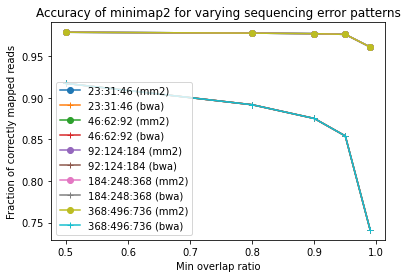

In [394]:
for ep in sorted(bwaOutcomesPerPattern.keys(), key=lambda k: int(k.split(':')[0])):
    plt.plot(THRESHOLDS, [float(miniOutcomesPerPattern[ep][t][1]) / sum(miniOutcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], 'o-', label=ep + " (mm2)")
    plt.plot(THRESHOLDS, [float(bwaOutcomesPerPattern[ep][t][1]) / sum(bwaOutcomesPerPattern[ep][t]) for t in \
                          THRESHOLDS], '+-', label=ep + " (bwa)")
    
plt.title("Accuracy of minimap2 for varying sequencing error patterns")
plt.xlabel("Min overlap ratio")
plt.ylabel("Fraction of correctly mapped reads")
plt.legend()
plt.show()

# Testing

In [81]:
a = "ACGT"
b = ["a", "c", "g"]
c = a[:1]

for i in range(len(b)):
    c += b[i] + a[1 + i * 1: (i + 2) * 1]
    
print(c)

AaCcGgT


In [73]:
seq = [i for i in range(4)]

print(seq.insert(4, "a"))
print(seq)

None
[0, 1, 2, 3, 'a']


In [256]:
elems = lines[1].split(' ')
print(elems[:6])
print(len(elems[6]))
print(len(elems[6].replace('-', "").replace('\n', "")))
print(int(elems[2]) + int(elems[3]))

['s', 'ref', '4066415', '14652', '+', '4900176']
15179
14652
4081067


In [257]:
nextLineElems = lines[2].strip().split(' ')
nextLineElems = [e for e in nextLineElems if e != '']
print(nextLineElems[:6])
print(len(nextLineElems[6]))
print(len(nextLineElems[6].replace('-', "")))

['s', 'S1_1', '0', '14447', '+', '14447']
15178
14447


In [264]:
from Bio import SeqIO

genome = [r for r in SeqIO.parse(open("../simulations/reads/SAL_GB9998AA_AS_cR103_ep23:31:46_0001.ref", 'r'), \
                                 "fasta")]
mappingPartGenome = genome[0].seq[4066415:4066415 + 14652]
mappingPartMAF = elems[6].strip().replace('-', "")[:14652]
print(mappingPartGenome == mappingPartMAF)

True


In [270]:
#Check out two more positions
from random import randint

otherPos = []

for i in range(2):
    otherPos.append(randint(0, len(lines) / 4))
    
print("Other positions reads are:")

for p in otherPos:
    print([e for e in lines[p * 4 + 1].split(' ') if e != ""][:6])
    print([e for e in lines[p * 4 + 2].split(' ') if e != ""][:6])

Other positions reads are:
['s', 'ref', '1059391', '8273', '+', '4900176']
['s', 'S1_4219', '0', '8144', '+', '8144']
['s', 'ref', '2798772', '3428', '+', '4900176']
['s', 'S1_1532', '0', '3359', '-', '3359']


In [278]:
from Bio.Seq import Seq

for p in otherPos:
    els = [e for e in lines[p * 4 + 1].strip().split(' ') if e != ""]
    nels = [e for e in lines[p * 4 + 2].strip().split(' ') if e != ""]
    
    #print(els[6][:10])
    readSeq = Seq(nels[6].replace('-', "")).reverse_complement()
    #print(genome[0].seq[int(els[2]):int(els[2]) + int(els[3])])
    print(els[6].replace('-', "") == genome[0].seq[int(els[2]):int(els[2]) + int(els[3])])
    #mpg = genome[0].seq[int(els[2]):int(els[2]) + int(els[3])]
    #
    #if nels[4] == '+':
    #    mpm = els[6].replace('-', "")
    #else:
    #    mpm = 

True
True


In [281]:
read = [r for r in SeqIO.parse(open("../simulations/reads/SAL_GB9998AA_AS_cR103_ep23:31:46_0001.fastq", 'r'), \
                               "fastq") if r.id == "S1_1532"][0].seq
read == readSeq

True

In [298]:
b["1"] = 0

NameError: name 'b' is not defined